### New file

In [1]:
# %matplotlib inline

# import io, os, sys, types
# from IPython import get_ipython
# from nbformat import read
# from IPython.core.interactiveshell import InteractiveShell


import math
import numpy as np
import os
from Distro_generation import get_dataset, get_q_batches, get_q_true

In [2]:
distros = ['mix', 'gau_1', 'gau_2', 'exp']
stepsizes = ['const', '2_div_sqrt_k', '0.002_div_sqrt_k']

tau_vals = [0.1, 0.3, 0.5, 0.9, 0.99]
N_g = 12 # N_generation
N_s = 10 # N_shuffle

# N_q = len(tau_vals)

# c_Norm = colors.Normalize(vmin=0, vmax=1)
# scalarMap = cmx.ScalarMappable(norm=c_Norm, cmap=plt.get_cmap('cool'))

In [21]:
# Check if folder exists, if not, then create new empty folders
def initialize_folders(fd_lst = ['Frugal_SGD', 'SGD'], main_fd = 'Experiment_results/'):
    
    for fd in fd_lst:
        if not os.path.exists(main_fd+fd):
            os.makedirs(main_fd+fd)

    sgd_lst = ['distro', 'data_size', 'step_size', 'data_sequence']        
    for fd in sgd_lst:
        fd_name = main_fd+'SGD/'+fd
        if not os.path.exists(fd_name):
            os.makedirs(fd_name)

initialize_folders()

In [4]:
def get_settings(distro_lst, datasize_lst, stepsize_lst):
    len_lst = [len(distro_lst), len(datasize_lst), len(stepsize_lst)]
    if len_lst.count(1) != len(len_lst)-1: 
#         if len_lst.count(1) == len(len_lst):
            
        raise Exception("Setting inputs are wrong!")
    
    N_settings = max((len_lst))
    setting_lst = []
    for lst in [distro_lst, datasize_lst, stepsize_lst]:
        if len(lst)==1: 
            lst = lst*N_settings
        setting_lst.append(lst)
        
    changed_setting = None
    change_lst = ['distro', 'data_size', 'step_size']
    for idx, l in enumerate(len_lst):
        if l>1: changed_setting = change_lst[idx]
    return np.asarray(setting_lst).T, changed_setting


In [5]:
# def set_stepsize(k, stepsize, length):
#     if stepsize=='const':
#         return 1 * np.ones(length)
#     elif stepsize=='2_div_sqrt_k':
#         return 2/math.sqrt(k)* np.ones(length)
#     elif stepsize=='0.002_div_sqrt_k':
#         return 0.002/math.sqrt(k) * np.ones(length)
#     raise Exception('stepsize parameter is wrong')
    
    
def set_stepsize(k, stepsize):
    if stepsize=='const':
        return 1
    elif stepsize=='2_div_sqrt_k':
        return 2/math.sqrt(k)
    elif stepsize=='0.002_div_sqrt_k':
        return 0.002/math.sqrt(k)
    raise Exception('stepsize parameter is wrong')

In [7]:
def get_procs(dataset, step_size, tau_lst):
    if len(dataset.shape)!= 1: 
        raise Exception('Dataset for get_procs() of wrong shape:' + str(dataset.shape)+ ', should be 1d array')
        
    procs = np.zeros((len(tau_lst), dataset.shape[0]))
    for idx, tau in enumerate(tau_lst):
        q = 0
        q_sgd_proc = procs[idx]
        # change stepsize
        if step_size != 'frugal':
            for k, x in enumerate(dataset):
#                 if idx==1: print (k, ':', q)
                alpha = set_stepsize(k+1, step_size)
                if x > q:
                    q = q + alpha*tau
                else:
                    q = q - alpha*(1-tau)
                q_sgd_proc[k] = q
        
        # frugal
        else:
            rdn_lst = np.random.uniform(0,1, dataset.shape[0])
            for k, x in enumerate(dataset):
                rdn = rdn_lst[k]
                if x > q and rdn > 1-tau:
                    q += 1
                elif x < q and rdn > tau:
                    q -= 1
                q_sgd_proc[k] = q
    return procs

In [8]:
def get_res(procs):
    if len(procs.shape)!=2:raise Exception('Procs of wrong shape:' + str(procs.shape)+ ', should be 2d array')
    return procs[:, -1]

In [9]:
def get_q_ests(dataset, step_size, tau_lst):

    if len(dataset.shape)>2:
        raise Exception('Dataset for q_est calculation of wrong shape: {}, should be 1d or 2d array'
                        .format(str(dataset.shape)))
    if len(dataset.shape)==1:
        procs = get_procs(dataset, step_size, tau_lst)
        res = get_res(procs)
    else:
        res = np.zeros((dataset.shape[0], len(tau_lst)))
        procs = np.zeros((dataset.shape[0], len(tau_lst), dataset.shape[1]))
        for idx, dt in enumerate(dataset):
            procs[idx] = get_procs(dt, step_size, tau_lst)
            res[idx] = get_res(procs[idx])
    return res, procs

In [10]:
# dataset = get_dataset('gau_1', 1000, g_test=True) * 50 - 200
# print(dataset.shape)

# # proc1 = get_procs(dataset, 'const', tau_vals)
# ## res1 = get_res(proc1)
# # proc2 = get_procs(dataset, 'frugal', tau_vals)
# # plt.plot(proc1.T)ad
# # plt.plot(proc2.T)
# # plt.show()


# res, proc = get_q_ests(dataset, 'const', tau_vals)
# print(res)
# print(proc)

In [11]:
def get_normalized_e(true, batches, est):
    upper = est - batches
    bottom = true - batches
    return (upper/bottom)

### Export data

In [12]:
def write_data(data, filename, setting=None):
    with open(filename, 'w') as outfile:
        if setting is not None: outfile.write('# Setting: {0}\n'.format(setting))
        if len(data.shape) == 1: data = data.reshape(-1, 1)
        outfile.write('# Array shape: {0}\n \n'.format(data.shape))

        for data_slice in data:
            np.savetxt(outfile, data_slice, fmt='%-15.8g')
            outfile.write('\n')


def write_data_overview(category, setting, tau_lst, file_name):
    with open(file_name, 'w') as f:
        f.write("Tested on "+category+": "+str(setting)+"\n") 
        f.write(str(tau_lst))
    
# write_data_overview('ca', 'se', tau_vals, "try.txt")
    
def save_data(foldername, file_name, tau_lst, data_dict):
    category, setting = file_name[0], file_name[1]    
    write_data_overview(category, setting, tau_lst, foldername+str(setting)+"_"+"overview.txt")

    for data_name in data_dict:
        print (foldername+str(setting)+"_"+data_name+'.txt')
        write_data(data_dict[data_name], foldername+str(setting)+"_"+data_name+'.txt')
        
    return

# save_data('', ('C', 'S'), tau_vals, {'dataset': np.reshape(np.random.uniform(0, 4, 100), (2, 5, 10))})

### Main functions 

In [13]:
def get_file_name(changed_setting, distro, datasize, stepsize, s_test):
#     print(changed_setting)
    if s_test:
        return ('Shuffle', True)
    setting_dict = {
        'distro': ('Distribution', distro),
        'data_size': ('Distribution', distro),
        'step_size': ('Step size', stepsize),
    }
    if not setting_dict.get(changed_setting): 
        raise Exception ('Cannot get file name')
    return setting_dict.get(changed_setting)

In [14]:
def get_shuffled_dataset(dataset, datasize, s_test):
    if not s_test: return dataset
    
    shuffled_dt = np.zeros((N_s, datasize))
    for i in range(N_s):
        np.random.shuffle(dataset)
        shuffled_dt[i] = dataset
    dataset = shuffled_dt
            
    return dataset

In [35]:
def quantile_sgd_compare(folder_name, distro_lst, datasize_lst, stepsize_lst, 
                         g_test=False, s_test=False, tau_lst=tau_vals, 
                        ):
    
    if g_test and s_test: raise Exception("g_test and s_test can't both be true")
    
    # generate different settings
    setting_lst, changed_setting = get_settings(distro_lst, datasize_lst, stepsize_lst,)
    print (setting_lst)
    
    # if only stepsize changes, generate dataset and q_batches
    dataset, q_batches = 0, 0
    if len(distro_lst)==1 and len(datasize_lst)==1:
        dataset = get_dataset(distro_lst[0], datasize_lst[0], g_test)
        q_batches = get_q_batches(dataset, tau_lst)
        
    # for each setting = [distro, datasize, stepsize]
    for idx, setting in enumerate(setting_lst):
        
        # generate all the data
        distro, datasize, stepsize = setting[0], int(setting[1]), setting[2]
        q_true = get_q_true(distro, tau_lst)
        if len(distro_lst)!=1 or len(datasize_lst)!=1:
            dataset = get_dataset(distro, datasize, g_test)
            q_batches = get_q_batches(dataset, tau_lst)
        if not s_test: 
            dataset = get_shuffled_dataset(dataset, datasize, s_test)
        q_est_res, q_est_proc = get_q_ests(dataset, stepsize, tau_lst)
        E = get_normalized_e(q_true, q_batches, q_est_res)
        
        data_dict = {
            'q_true': q_true,
            'q_batches': q_batches,
            'q_est_res': q_est_res,
            'q_est_proc': q_est_proc,
            'E': E
        }
        # generate charts and tables?
        file_name = get_file_name(changed_setting, distro, datasize, stepsize, s_test)
        save_data(folder_name, file_name, tau_lst, data_dict)

In [40]:
sgd_lst = ['distro', 'data_size', 'step_size', 'data_sequence']        

def all_sgd_comparisons(sgd_lst, root_folder='SGD'):
    
    args_dict = {
        'distro': (distros, [1000], ['const'], True),
        'data_size': (['gau_2'], [100, 1000, 10000], ['const'], True),
        'step_size': (['gau_1'], [1000], stepsizes, True),
        'data_sequence':(['gau_1', 'gau_1'], [1000], ['const'], False, True),
    }
    
    for t in sgd_lst:
        print (t)
        folder_name = "Experiment_results/{}/{}/".format(root_folder, t)
        
        args = args_dict.get(t)
        distro_lst, datasize_lst, stepsize_lst =  args[0], args[1], args[2]
        g_test = args[3]
        s_test = False if len(args)<5 else args[4]
        tau_lst = tau_vals
        
        quantile_sgd_compare(folder_name, distro_lst, datasize_lst, stepsize_lst, g_test, s_test, tau_lst)
            

In [41]:
# Run all functions

main_folder = 'SGD'
all_sgd_comparisons(sgd_lst, main_folder)

distro
[['mix' '1000' 'const']
 ['gau_1' '1000' 'const']
 ['gau_2' '1000' 'const']
 ['exp' '1000' 'const']]
Experiment_results/SGD/distro/mix_q_true.txt
Experiment_results/SGD/distro/mix_q_batches.txt
Experiment_results/SGD/distro/mix_q_est_res.txt
Experiment_results/SGD/distro/mix_q_est_proc.txt
Experiment_results/SGD/distro/mix_E.txt
Experiment_results/SGD/distro/gau_1_q_true.txt
Experiment_results/SGD/distro/gau_1_q_batches.txt
Experiment_results/SGD/distro/gau_1_q_est_res.txt
Experiment_results/SGD/distro/gau_1_q_est_proc.txt
Experiment_results/SGD/distro/gau_1_E.txt
Experiment_results/SGD/distro/gau_2_q_true.txt
Experiment_results/SGD/distro/gau_2_q_batches.txt
Experiment_results/SGD/distro/gau_2_q_est_res.txt
Experiment_results/SGD/distro/gau_2_q_est_proc.txt
Experiment_results/SGD/distro/gau_2_E.txt
Experiment_results/SGD/distro/exp_q_true.txt
Experiment_results/SGD/distro/exp_q_batches.txt
Experiment_results/SGD/distro/exp_q_est_res.txt
Experiment_results/SGD/distro/exp_q_est_p

In [33]:
# def sgd_frugal_compare(distro_lst, datasize, tau_lst=tau_vals):
#     #distro changes, use the biggest datasize, do not shuffle
#     for distro in distro_lst:
#         q_true = get_q_true(distro, tau_lst)
#         dataset = get_dataset(distro, datasize, False)
#         q_batches = get_q_batches(dataset, tau_lst)
        
#         sgd_res, sgd_proc = get_q_ests(dataset, 'const', tau_lst)
        
#         N_frugal = 20
#         frugal_res = np.zeros((N_frugal, len(tau_lst)))
#         frugal_proc = np.zeros((N_frugal, len(tau_lst), datasize))
#         for i in range(N_frugal):
#             frugal_res[i], frugal_proc[i] = get_q_ests(dataset, 'frugal', tau_lst)
        
#         ax_name = 'Tested on '+distro+' distritbution with '+str(datasize)+' data points'
#         fig, lgd = plot_procs(ax_name, tau_vals, q_true, frugal_proc, sgd_proc)
#         title = fig.suptitle('Quantile Estimation: Frugal vs SGD')

#         fd = "Experiment_results/Frugal_SGD/"
#         plt.savefig(fd+distro+'.png', bbox_extra_artists=(lgd, title), bbox_inches='tight')
        
        
# sgd_frugal_compare(distros, 1000)

<!---
### Always have $q_k = x$ for each x in the data stream

When $x - q_k > 0$, we have $l(q_k) = \tau(x-q_k)$:
\begin{align}
q_{k+1} & = q_k - \frac{l(q_k)}{l'(q_k)} \\
        & = q_k - \frac{\tau(x-q_k)}{-\tau} \\
        & = q_k - (- x + q_k) \\
        & = x
\end{align}

Same happens when $x - q_k < 0$
-->

Experiment_results/SGD/data_sequence/True_


IndexError: index 1 is out of bounds for axis 0 with size 1

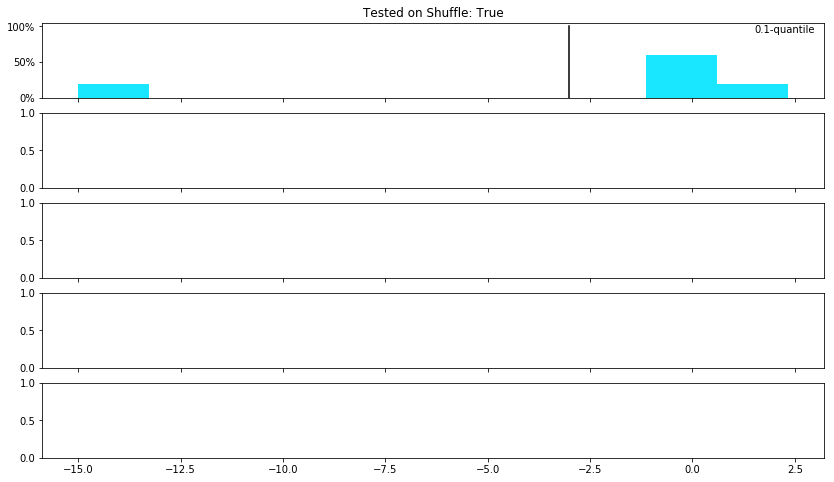

In [42]:
from Plot import plot_charts

plot_charts("Experiment_results/SGD/data_sequence".format(main_folder))